# LLMs based Forecasting（via DeepSeek API）

## Feng Li

### Guanghua School of Management
### Peking University

### [feng.li@gsm.pku.edu.cn](feng.li@gsm.pku.edu.cn)
### Course home page: [https://feng.li/forecasting-with-ai](https://feng.li/forecasting-with-ai)


## Let’s forecast

我们在这里使用 **DeepSeek API** 来完成“用历史乘客（passenger）数据预测未来几期”的任务。

In [5]:
! pip install openai --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## Load the DeepSeek API

### 如何申请 DeepSeek API Key
1. 登录 DeepSeek 平台的 API Keys 页面 (https://platform.deepseek.com/api_keys) 创建 Key 。
2. 点击创建 API KEY
3. 输入 API KEY 的名称
4. 复制 API KEY。⚠️请注意，一定要立刻复制

### Use the DeepSeek API

In [6]:
import json, re, pandas as pd
from openai import OpenAI

In [ ]:
DEEPSEEK_API_KEY = "YOUR_DEEPSEEK_API_KEY"  # ← 替换为你的真实 Key
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com/v1")

## 读取 passenger 数据

要求列：`unique_id`, `ds`, `y`

In [7]:
data_path = "../data/air_passengers_with_id.csv"
df = pd.read_csv(data_path)
df.columns = [c.lower() for c in df.columns]
df["ds"] = pd.to_datetime(df["ds"], errors="raise")   # 把时间列转化成 Pandas 的时间格式
df = df.sort_values(["unique_id","ds"]).reset_index(drop=True)
uid = df["unique_id"].iloc[0]
df

,unique_id,ds,y
0,D1,1949-01-01,112
1,D1,1949-02-01,118
2,D1,1949-03-01,132
3,D1,1949-04-01,129
4,D1,1949-05-01,121
...,...,...,...
139,D1,1960-08-01,606
140,D1,1960-09-01,508
141,D1,1960-10-01,461
142,D1,1960-11-01,390


## 可视化原始时间序列

<Axes: title={'center': 'D1 — history'}, xlabel='ds'>

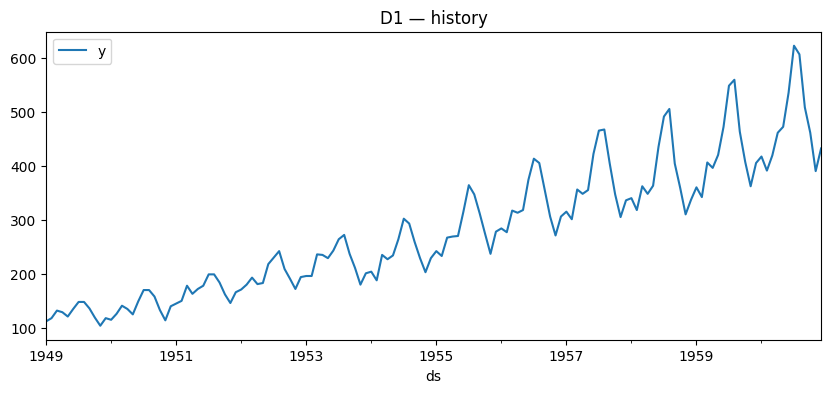

In [5]:
df_plot = df[df['unique_id']==uid].sort_values('ds').set_index('ds')
df_plot['y'].plot(title=f'{uid} — history', figsize=(10,4), legend=True)

## DeepSeek 预测
我们通过提示词约定 **严格 JSON** 输出，并解析为 DataFrame。

In [8]:
def build_prompt(df, h=12, freq='MS', tail=120):
    sub = df[df['unique_id']==uid].sort_values('ds').tail(tail)
    hist = [{'ds': r.ds.strftime('%Y-%m-%d'), 'y': float(r.y)} for r in sub.itertuples(index=False)]
    return (
        f'你是一名时间序列预测助手。下面给出乘客序列的历史数据（频率 {freq}）。\n'
        f'请预测未来 {h} 期，并**只输出严格 JSON**。\n\n'
        f'【历史数据】\n{json.dumps(hist, ensure_ascii=False, indent=2)}\n\n'
        '{\n'
        f'  "h": {h},\n'
        f'  "freq": "{freq}",\n'
        '  "forecast": [ { "ds": "YYYY-MM-DD", "yhat": <float> } ]\n'
        '}'
    )


In [9]:
prompt = build_prompt(df, h=12, freq='MS')
prompt

'你是一名时间序列预测助手。下面给出乘客序列的历史数据（频率 MS）。\n请预测未来 12 期，并**只输出严格 JSON**。\n\n【历史数据】\n[\n  {\n    "ds": "1951-01-01",\n    "y": 145.0\n  },\n  {\n    "ds": "1951-02-01",\n    "y": 150.0\n  },\n  {\n    "ds": "1951-03-01",\n    "y": 178.0\n  },\n  {\n    "ds": "1951-04-01",\n    "y": 163.0\n  },\n  {\n    "ds": "1951-05-01",\n    "y": 172.0\n  },\n  {\n    "ds": "1951-06-01",\n    "y": 178.0\n  },\n  {\n    "ds": "1951-07-01",\n    "y": 199.0\n  },\n  {\n    "ds": "1951-08-01",\n    "y": 199.0\n  },\n  {\n    "ds": "1951-09-01",\n    "y": 184.0\n  },\n  {\n    "ds": "1951-10-01",\n    "y": 162.0\n  },\n  {\n    "ds": "1951-11-01",\n    "y": 146.0\n  },\n  {\n    "ds": "1951-12-01",\n    "y": 166.0\n  },\n  {\n    "ds": "1952-01-01",\n    "y": 171.0\n  },\n  {\n    "ds": "1952-02-01",\n    "y": 180.0\n  },\n  {\n    "ds": "1952-03-01",\n    "y": 193.0\n  },\n  {\n    "ds": "1952-04-01",\n    "y": 181.0\n  },\n  {\n    "ds": "1952-05-01",\n    "y": 183.0\n  },\n  {\n    "ds": "1952-06-01",\n    "y"

In [7]:
# 我们写一个函数解析一下JSON的输出
def parse_json(text):
    try: return json.loads(text)
    except: pass
    if '```' in text:
        for part in text.split('```'):
            p = part.strip()
            if p.lower().startswith('json'): p = p[4:].strip()
            try: return json.loads(p)
            except: pass
    m = re.search(r'\{[\s\S]*\}', text)
    if m: return json.loads(m.group(0))
    raise ValueError('无法解析JSON: '+text[:200])

### 6期预测（short horizon）

In [10]:
prompt = build_prompt(df, h=6, freq='MS')
resp = client.chat.completions.create(model='deepseek-chat', messages=[{'role':'user','content':prompt}], temperature=0)
raw = resp.choices[0].message.content
obj = parse_json(raw)
fc6 = pd.DataFrame(obj['forecast']).assign(unique_id=uid)
fc6['ds'] = pd.to_datetime(fc6['ds'])
fc6['yhat'] = pd.to_numeric(fc6['yhat'], errors='coerce')
fc6 = fc6.dropna().sort_values('ds').reset_index(drop=True)
fc6.head()

,ds,yhat,unique_id
0,1961-01-01,445.2,D1
1,1961-02-01,420.1,D1
2,1961-03-01,488.3,D1
3,1961-04-01,475.6,D1
4,1961-05-01,496.8,D1


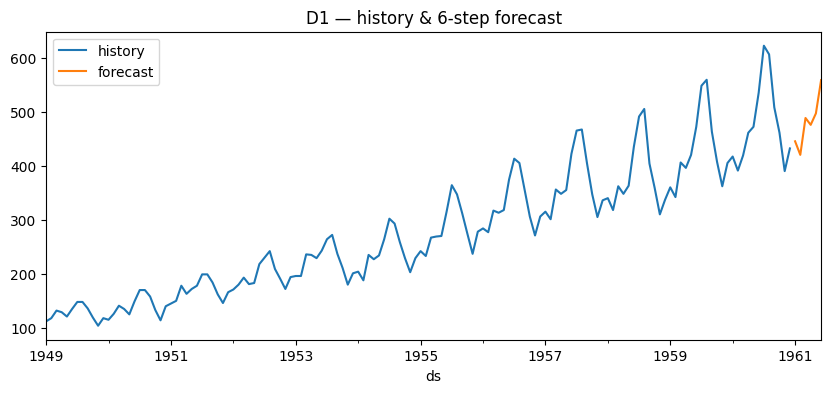

In [11]:
hist = df[df['unique_id']==uid].sort_values('ds').set_index('ds')
fc_plot = fc6.set_index('ds')
ax = hist['y'].plot(label='history', figsize=(10,4))
fc_plot['yhat'].plot(ax=ax, label='forecast')
ax.set_title(f"{uid} — history & 6-step forecast")
ax.legend()


### 12 期预测

In [8]:
prompt = build_prompt(df, h=12, freq='MS')
resp = client.chat.completions.create(model='deepseek-chat', messages=[{'role':'user','content':prompt}], temperature=0)
raw = resp.choices[0].message.content
obj = parse_json(raw)
fc12 = pd.DataFrame(obj['forecast']).assign(unique_id=uid)
fc12['ds'] = pd.to_datetime(fc12['ds'])
fc12['yhat'] = pd.to_numeric(fc12['yhat'], errors='coerce')
fc12 = fc12.dropna().sort_values('ds').reset_index(drop=True)
fc12.head()

,ds,yhat,unique_id
0,1961-01-01,444.2,D1
1,1961-02-01,422.1,D1
2,1961-03-01,456.8,D1
3,1961-04-01,478.3,D1
4,1961-05-01,492.6,D1


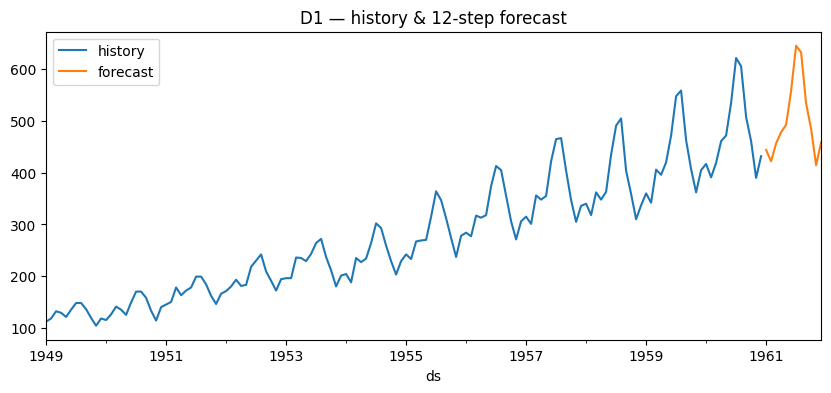

In [9]:
hist = df[df['unique_id']==uid].sort_values('ds').set_index('ds')
fc_plot = fc12.set_index('ds')
ax = hist['y'].plot(label='history', figsize=(10,4))
fc_plot['yhat'].plot(ax=ax, label='forecast')
ax.set_title(f"{uid} — history & 12-step forecast")
ax.legend()


### 36期预测（long horizon）

In [12]:
prompt = build_prompt(df, h=36, freq='MS')
resp = client.chat.completions.create(model='deepseek-chat', messages=[{'role':'user','content':prompt}], temperature=0)
raw = resp.choices[0].message.content
obj = parse_json(raw)
fc36 = pd.DataFrame(obj['forecast']).assign(unique_id=uid)
fc36['ds'] = pd.to_datetime(fc36['ds'])
fc36['yhat'] = pd.to_numeric(fc36['yhat'], errors='coerce')
fc36 = fc36.dropna().sort_values('ds').reset_index(drop=True)
fc36.head()

,ds,yhat,unique_id
0,1961-01-01,445.2,D1
1,1961-02-01,420.1,D1
2,1961-03-01,461.8,D1
3,1961-04-01,475.3,D1
4,1961-05-01,489.6,D1


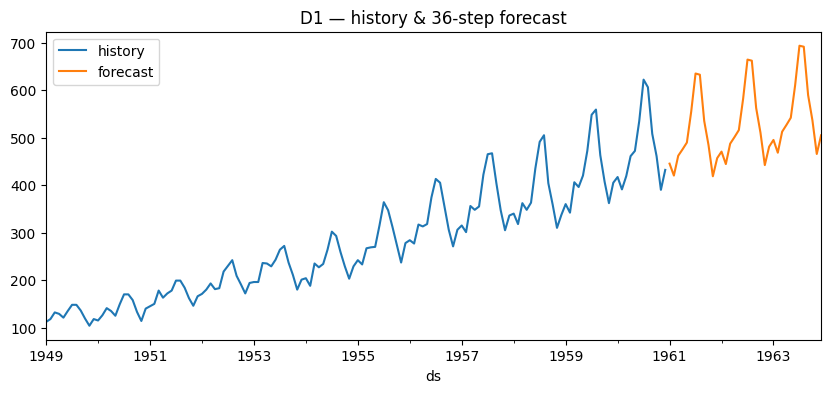

In [13]:
hist = df[df['unique_id']==uid].sort_values('ds').set_index('ds')
fc_plot = fc36.set_index('ds')
ax = hist['y'].plot(label='history', figsize=(10,4))
fc_plot['yhat'].plot(ax=ax, label='forecast')
ax.set_title(f"{uid} — history & 36-step forecast")
ax.legend()


## Lab

- 请找一个你自己的数据，调整成 `air_passengers_with_id.csv` 的格式。
- 使用我们上面的程序做一个预测，利用你的行业知识评估一下一下这个预测是否是一个可靠的预测。